In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import re
from scipy.stats import lognorm
from scipy.special import expit

from bids import BIDSLayout

import pymc as pm
import arviz as az

In [2]:
# hard-coded values
BIDS_ROOT = 'bids_dataset'
DERIV_ROOT = os.path.join(BIDS_ROOT, 'derivatives')

In [3]:
# prepare trial data for multilevel model
layout = BIDSLayout(BIDS_ROOT)
ev_files = layout.get(
    return_type = 'file', 
    suffix = 'events',
    extension = 'tsv'
)

removed_ct = 0
events = []
for i, f in enumerate(ev_files):
    # load subjects' event data
    ev = pd.read_csv(f, sep = '\t')
    ev['subject'] = np.full(ev.shape[0], i)

    # remove outliers (i.e. ineffective stimulation)
    rm_idx = (ev.pressed_first == True) & (ev.trial_type == 'stimulation')
    rm_idx = (ev.rt > .6) | rm_idx
    ev = ev[~rm_idx]
    removed_ct += rm_idx.sum()
    movement_lag = ev.rt - ev.latency
    params = lognorm.fit(movement_lag[ev.trial_type == 'stimulation'])
    lower = lognorm.ppf(.025, params[0], params[1], params[2])
    upper = lognorm.ppf(.975, params[0], params[1], params[2])
    ev['outlier'] = (movement_lag > upper) | (movement_lag < lower)
    #removed_ct += ev.outlier.sum()
    events.append(ev)
events = pd.concat(events)
events['lag'] = events.rt - events.latency

In [4]:
# removed by hard selection criteria per subject
removed_ct / np.unique(events.subject).size

18.391304347826086

In [5]:
# removed by outlier detection per subject
events.outlier.sum() / np.unique(events.subject).size

12.391304347826088

In [6]:
outliers = events[events.outlier]
events = events[~events.outlier]

## Estimate RTs per condition (manipulation check)

In [7]:
import bambi as bmb
model = bmb.Model(
    "rt ~ trial_type + (1 + trial_type|subject)", 
    events, family = "gaussian"
)
trace = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [rt_sigma, Intercept, trial_type, 1|subject_sigma, 1|subject_offset, trial_type|subject_sigma, trial_type|subject_offset]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 1400 seconds.


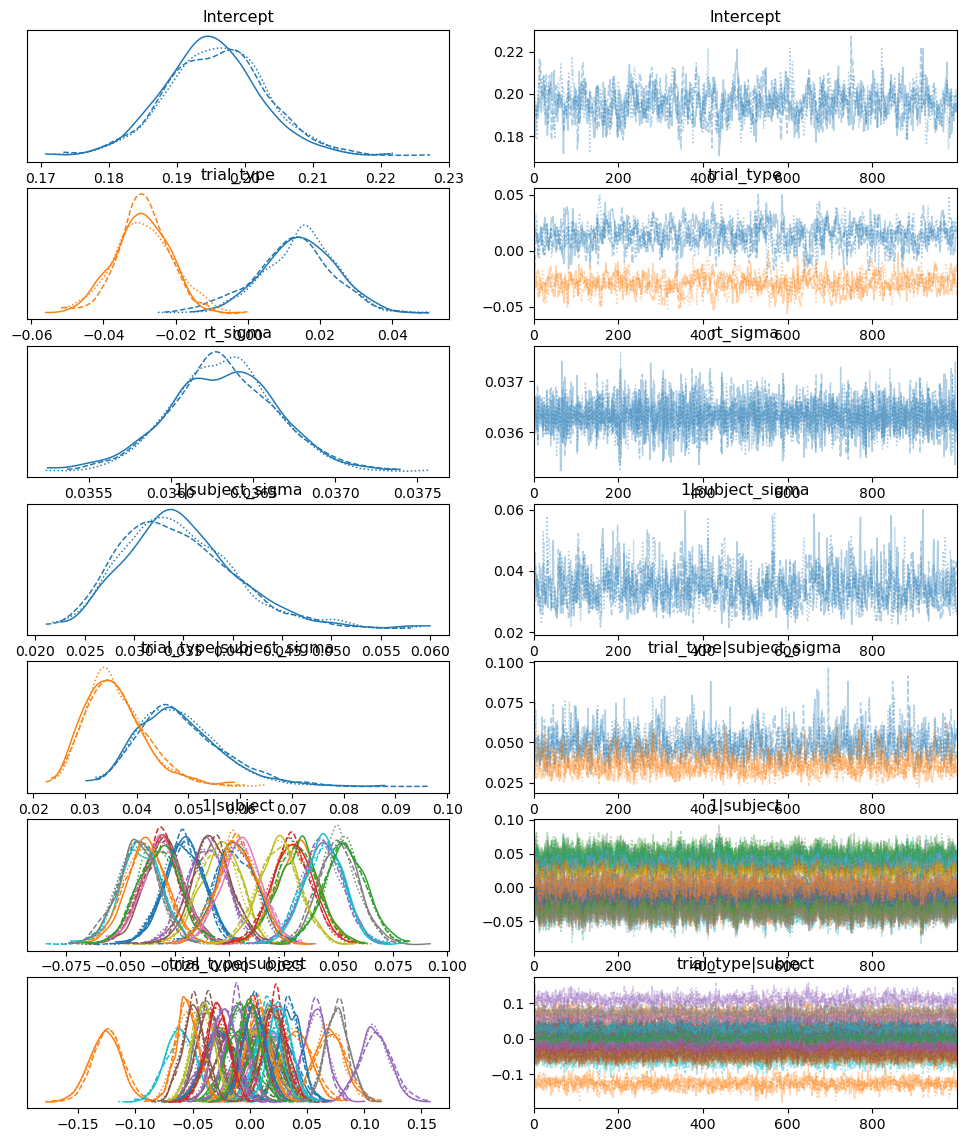

In [8]:
axs = az.plot_trace(trace)

In [9]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.196,0.007,0.182,0.209,0.000,0.0,596.0,1047.0,1.00
trial_type[pretest],0.014,0.011,-0.007,0.033,0.001,0.0,411.0,727.0,1.01
trial_type[stimulation],-0.029,0.008,-0.044,-0.014,0.000,0.0,377.0,647.0,1.01
rt_sigma,0.036,0.000,0.036,0.037,0.000,0.0,5571.0,1655.0,1.00
1|subject_sigma,0.035,0.006,0.024,0.045,0.000,0.0,828.0,1348.0,1.00
...,...,...,...,...,...,...,...,...,...
"trial_type|subject[stimulation, 18]",-0.055,0.010,-0.073,-0.036,0.000,0.0,604.0,947.0,1.00
"trial_type|subject[stimulation, 19]",-0.000,0.010,-0.018,0.020,0.000,0.0,617.0,1428.0,1.00
"trial_type|subject[stimulation, 20]",-0.029,0.010,-0.047,-0.009,0.000,0.0,651.0,1280.0,1.00
"trial_type|subject[stimulation, 21]",-0.022,0.010,-0.042,-0.004,0.000,0.0,587.0,1189.0,1.00


In [10]:
# get posterior samples for each condition's reaction time
trc = trace.posterior.stack(draws = ("chain", "draw"))
pre_rt = trc['Intercept'].values + trc['trial_type'][0].values
stim_rt = trc['Intercept'].values + trc['trial_type'][1].values
post_rt = trc['Intercept'].values 

# compile into pandas dataframe for easier plotting
n_samples = pre_rt.shape[0]
rt = np.concatenate([pre_rt, stim_rt, post_rt])
condition = np.concatenate([
    np.repeat('pre', n_samples),
    np.repeat('stim', n_samples),
    np.repeat('post', n_samples)
])
posterior_df = pd.DataFrame({'reaction time (s)': rt, 'condition': condition})

# also get subject-specific parameter posteriors
pre_rt_subs = pre_rt + trc['1|subject'].values + trc['trial_type|subject'][0].values
stim_rt_subs = stim_rt + trc['1|subject'].values + trc['trial_type|subject'][1].values
post_rt_subs = post_rt + trc['1|subject'].values 

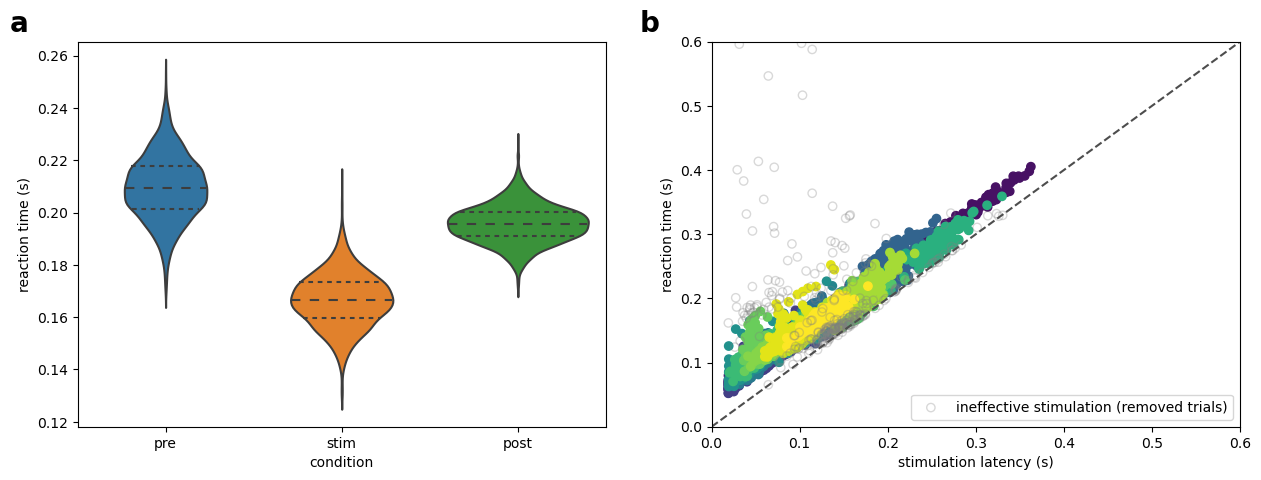

In [37]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

# plot RT posteriors
from seaborn import violinplot
violinplot(
    posterior_df, 
    x = 'condition', y = 'reaction time (s)', 
    inner = 'quartile',
    ax = axs[0]
)

# plot reaction time vs. stimulation latency
ev = events[~events.outlier]
axs[1].scatter(ev.latency, ev.rt, c = ev.subject)
axs[1].scatter(
    outliers.latency, outliers.rt, 
    facecolors = 'none',
    edgecolors = 'grey',
    alpha = .3,
    label = 'ineffective stimulation (removed trials)'
)
axs[1].plot([0, .6], [0, .6], ls = '--', c = '.3')
axs[1].set_ylim(0, .6)
axs[1].set_xlim(0, .6)
axs[1].set_xlabel('stimulation latency (s)')
axs[1].set_ylabel('reaction time (s)')
axs[1].legend()

# add panel labels
fig.text(.08, .9, 'a', size = 20, weight = 'bold') 
fig.text(.5, .9, 'b', size = 20, weight = 'bold')
plt.savefig('rts.jpeg', dpi = 500)
plt.show()

In [23]:
# probability stim trials are faster than pre trials
(pre_rt > stim_rt).mean()

0.9996666666666667

In [24]:
az.hdi(pre_rt - stim_rt)

array([0.01752235, 0.0650406 ])

In [25]:
# probability stim trials are faster than post trials
(post_rt > stim_rt).mean()

0.9996666666666667

In [26]:
az.hdi(post_rt - stim_rt)

array([0.01381372, 0.04386308])

In [27]:
(pre_rt > post_rt).mean() # probability of pre-to-post speedup

0.906

In [28]:
az.hdi(pre_rt - post_rt)

array([-0.006711  ,  0.03284535])

In [29]:
events[events.subject == 0].trial_type == 'stimulation'

0      False
1      False
2      False
3      False
4      False
       ...  
305    False
306    False
307    False
308    False
309    False
Name: trial_type, Length: 288, dtype: bool

## Trial breakdown

In [30]:
stim_trials = events[events.trial_type == 'stimulation']
(stim_trials.agency).mean()

0.5197863078749505

In [31]:
prop_agency = []
for sub in np.unique(events.subject):
    events_sub = events[events.subject == sub]
    stim_trials = events_sub[events_sub.trial_type == 'stimulation']
    prop_agency.append(stim_trials.agency.mean())
prop_agency = np.array(prop_agency)
prop_mean = prop_agency.mean()
prop_sd = prop_agency.std()
print('Mean subject had %.02f%% agency trials, SD = %.02f%%'%(100*prop_mean, prop_sd))

Mean subject had 50.99% agency trials, SD = 0.14%


## Plot example stimulation time series

In [32]:
df = pd.read_csv(ev_files[6], sep = '\t')
df

,onset,duration,trial_type,trial,intensity,latency,rt,pressed_first,agency
0,14.5133,0.4524,pretest,1,0.0,NaN,0.40971,1,1
1,21.1634,0.2691,pretest,2,0.0,NaN,0.22207,1,1
2,26.8635,0.2524,pretest,3,0.0,NaN,0.20063,1,1
3,32.4636,0.2524,pretest,4,0.0,NaN,0.19895,1,1
4,37.5470,0.2191,pretest,5,0.0,NaN,0.17028,1,1
...,...,...,...,...,...,...,...,...,...
305,2188.5796,0.2523,posttest,26,0.0,NaN,0.19759,1,1
306,2194.3463,0.1857,posttest,27,0.0,NaN,0.14150,1,1
307,2199.5131,0.2023,posttest,28,0.0,NaN,0.15739,1,1
308,2216.2967,0.1856,posttest,29,0.0,NaN,0.13758,1,1


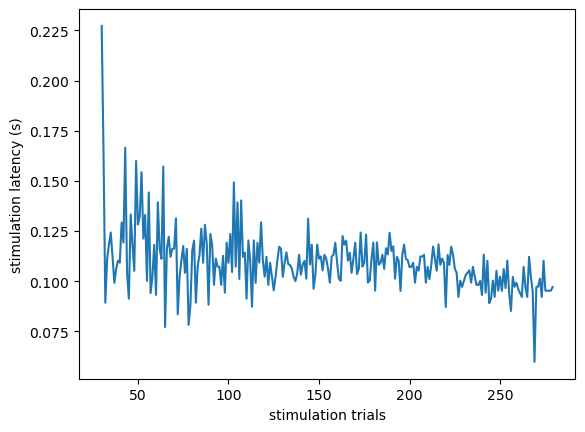

In [33]:
plt.plot(df[df.trial_type == 'stimulation'].latency)
plt.xlabel('stimulation trials')
plt.ylabel('stimulation latency (s)')
plt.ylabel
plt.show()

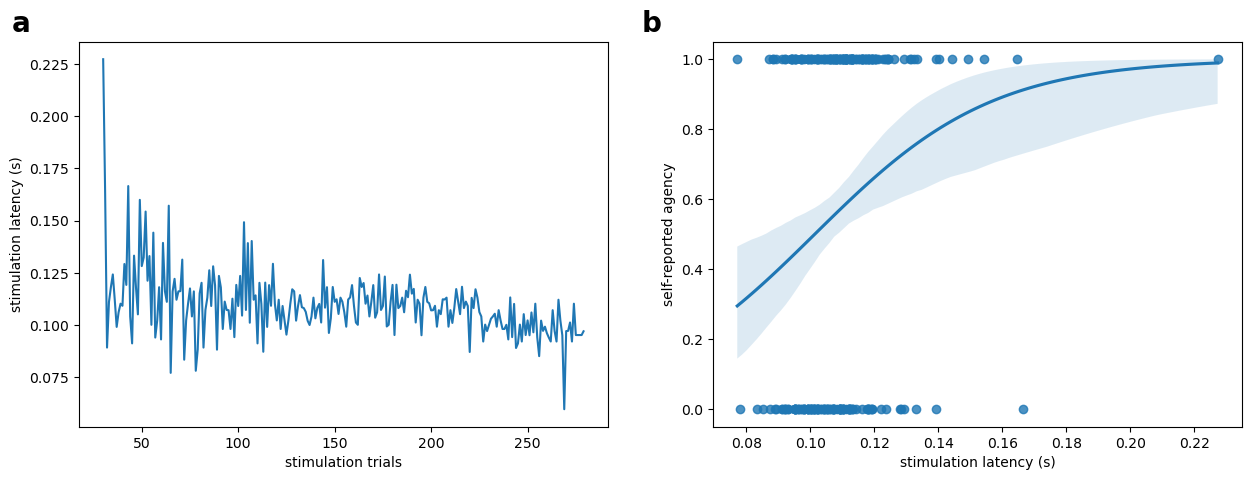

This subject was preempted on 98 percent of stimulation trials,
and they felt agency on 56 percent of preempted trials.


In [34]:
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize = (15, 5))

axs[0].plot(df[df.trial_type == 'stimulation'].latency)
axs[0].set_xlabel('stimulation trials')
axs[0].set_ylabel('stimulation latency (s)')

stim_trials = df[df.pressed_first == 0]
sns.regplot(
    x = 'latency', y = 'agency',
    data = stim_trials,
    logistic = True,
    ax = axs[1]
)
axs[1].set_xlabel('stimulation latency (s)')
axs[1].set_ylabel('self-reported agency')

# add panel labels
fig.text(.08, .9, 'a', size = 20, weight = 'bold') 
fig.text(.5, .9, 'b', size = 20, weight = 'bold')
plt.savefig('bopt.jpeg', dpi = 500)
plt.show()

n_stims = df[df.trial_type == 'stimulation'].shape[0]
print('This subject was preempted on %d percent of stimulation trials,'%(
    stim_trials.shape[0]/n_stims * 100
))
print('and they felt agency on %d percent of preempted trials.'%(
    stim_trials.agency.mean() * 100
))